In [35]:
import billboard
import pandas as pd
from collections import Counter
import numpy as np
from multiprocessing import Pool
import re
import matplotlib.pyplot as plt

In [322]:
CHART         = 'hot-100'

def unique_top_tracks_generator():
    seen_tracks = list()
    for Year in range(2000, 2019):
        START_DATE = str(Year)+'-08-31'
        chart = billboard.ChartData(CHART, date=START_DATE)
        while chart.previousDate > str(Year) + '-06-01':
            for i, track in enumerate(chart[:50]):
                seen_tracks.append(track.title + '//' + track.artist + '//' + str(Year) + '//' + str(i))
            chart = billboard.ChartData(CHART, date=chart.previousDate)
        
    return seen_tracks    

In [323]:
u = unique_top_tracks_generator()

In [324]:
grades = dict()
for elt in u:
    k=elt.rfind('//')
    song=elt[:k]
    if song in grades:
        grades[song] += 50-int(elt[k+2:])
    else:
        grades[song] = 50-int(elt[k+2:])

In [332]:
list(grades.keys())
list(grades.values())

[344,
 247,
 404,
 573,
 324,
 580,
 262,
 327,
 490,
 572,
 367,
 194,
 603,
 108,
 494,
 523,
 433,
 583,
 306,
 371,
 58,
 142,
 60,
 46,
 74,
 58,
 197,
 174,
 458,
 467,
 112,
 42,
 472,
 29,
 106,
 15,
 60,
 35,
 156,
 270,
 10,
 9,
 406,
 205,
 6,
 7,
 7,
 177,
 2,
 308,
 112,
 154,
 71,
 52,
 8,
 310,
 150,
 187,
 418,
 70,
 372,
 1,
 208,
 267,
 238,
 53,
 277,
 159,
 169,
 143,
 126,
 65,
 63,
 79,
 124,
 43,
 64,
 83,
 28,
 65,
 24,
 31,
 25,
 22,
 20,
 11,
 3,
 4,
 3,
 299,
 295,
 326,
 388,
 579,
 398,
 478,
 418,
 564,
 586,
 553,
 425,
 344,
 134,
 341,
 476,
 128,
 179,
 470,
 49,
 145,
 182,
 87,
 448,
 77,
 51,
 199,
 71,
 443,
 41,
 52,
 79,
 230,
 31,
 38,
 18,
 361,
 42,
 159,
 435,
 321,
 209,
 61,
 80,
 6,
 5,
 440,
 3,
 169,
 250,
 147,
 102,
 332,
 81,
 332,
 424,
 223,
 259,
 103,
 160,
 70,
 83,
 116,
 266,
 184,
 267,
 39,
 55,
 109,
 104,
 77,
 92,
 74,
 74,
 27,
 129,
 90,
 89,
 34,
 49,
 60,
 38,
 34,
 28,
 18,
 17,
 11,
 9,
 3,
 2,
 1,
 315,
 594,
 481,


In [418]:
notes = pd.DataFrame(list(grades.values()))
songs = pd.DataFrame(list(grades.keys()))
s=songs[0].str.split('//')
df=pd.DataFrame.from_items(zip(s.index, s.values)).T
df.columns = ['Title', 'Artist', 'Year']
df=df.join(notes)
df['has_lyrics']=np.nan
df['track_id']=np.nan
df['genre']=np.nan
df['language']=np.nan
df['instrumental']=np.nan
df['lyrics']=np.nan

/Users/jean-baptiste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  after removing the cwd from sys.path.


In [30]:
df.to_csv('Summer_songs_lyrics.csv')

In [6]:
import requests


def lyrics(song, artist):
    key = '26cc996c835cca5e9941d0c6a77ad8d1'
    get_track = "https://api.musixmatch.com/ws/1.1/track.search?apikey={}&q_track={}&q_artist={}&f_has_lyrics=1&s_track_rating=desc".format(key, song, artist)

    res = requests.get(get_track)
    res_data = res.json()
    song_info = {}
    try:
        track = res_data['message']['body']['track_list'][0]['track']

        song_info['id'] = track['track_id']
        song_info['has_lyrics'] = track['has_lyrics']
        song_info['album'] = track['album_name']
        song_info['song_name'] = track['track_name']
        song_info['artist'] = track['artist_name']
        try:
            song_info['genre'] = track['primary_genres']['music_genre_list'][0]['music_genre']['music_genre_name']
        except:
            song_info['genre'] = np.nan

        get_lyrics = "https://api.musixmatch.com/ws/1.1/track.lyrics.get?apikey=26cc996c835cca5e9941d0c6a77ad8d1&track_id={}".format(song_info['id'])
        res = requests.get(get_lyrics)
        res_data = res.json()

        lyric = res_data['message']['body']['lyrics']

        song_info['language'] = lyric['lyrics_language_description']
        song_info['instrumental'] = lyric['instrumental']
        song_info['lyrics'] = lyric['lyrics_body'].replace("\n...\n\n******* This Lyrics is NOT for Commercial use *******", "")

    except:
        song_info['id'] = np.nan
        song_info['has_lyrics'] = np.nan
        song_info['album'] = np.nan
        song_info['song_name'] = np.nan
        song_info['artist'] = np.nan
        song_info['genre'] = np.nan
        song_info['language'] = np.nan
        song_info['instrumental'] = np.nan
        song_info['lyrics'] = np.nan

    return song_info['has_lyrics'], song_info['id'], song_info['genre'], song_info['language'], song_info['instrumental'], song_info['lyrics']


In [27]:
def f(i):
    return lyrics(df.iloc[i,0], re.sub(' Featuring.*', '', df.iloc[i,1]))

In [28]:
indexes = list(range(len(df)))
if __name__ == '__main__':
    p = Pool(10)
    elts = p.map(f, indexes)
    
for i, index in enumerate(indexes):
    df.iloc[index,4], df.iloc[index,5], df.iloc[index,6], df.iloc[index,7], df.iloc[index,8], df.iloc[index,9] = elts[i]

In [127]:
genre_year=df.loc[:, ['genre', 'Year']].pivot_table(index="genre", columns="Year", aggfunc=len, fill_value=0)
genre_year = g

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
genre,,,,,,,,,,,,,,,,,,,
Adult Contemporary,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0
Alternative,2,2,2,2,1,5,5,5,3,6,2,3,4,6,6,3,1,2,1
Alternative Rap,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,2,2,1
Classical Crossover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Contemporary Country,0,0,0,0,0,0,0,0,1,0,3,0,1,1,0,2,0,0,2
Contemporary Folk,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Contemporary R&B,0,1,0,1,1,0,2,0,4,1,0,2,1,3,6,1,2,2,2
Country,17,17,14,12,16,9,10,9,11,13,14,18,15,18,14,14,12,8,9


In [130]:
genres = list(genre_year.sum(axis=1).sort_values(ascending=False).head().index)
genre_year = genre_year.loc[genres, :]

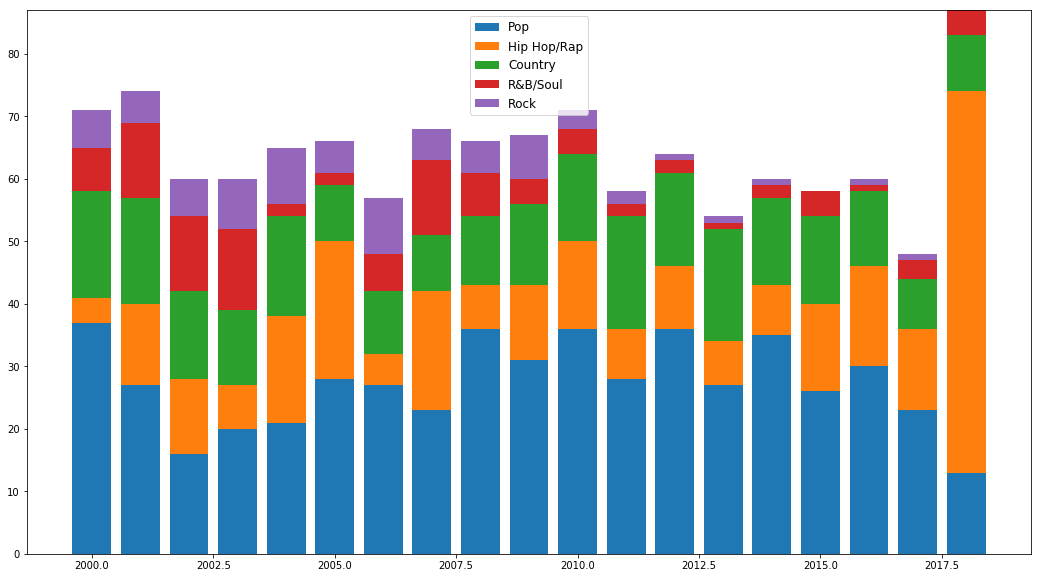

In [134]:
genres = list(genre_year.sum(axis=1).sort_values(ascending=False).head().index)

plt.figure(figsize=(18, 10))
plt.bar(list(range(2000, 2019)), genre_year.iloc[0, :])
plt.bar(list(range(2000, 2019)), genre_year.iloc[1, :], bottom=genre_year.iloc[0, :])
plt.bar(list(range(2000, 2019)), genre_year.iloc[2, :], bottom=genre_year.iloc[:2, :].sum())
plt.bar(list(range(2000, 2019)), genre_year.iloc[3, :], bottom=genre_year.iloc[:3, :].sum())
plt.bar(list(range(2000, 2019)), genre_year.iloc[4, :], bottom=genre_year.iloc[:4, :].sum())
#for i in range(1, 4):
#    plt.bar(list(range(2000, 2019)), genre_year.iloc[i, :], bottom=genre_year.iloc[:i-1, :].sum())
plt.legend(genres, prop={'size': 12})
plt.show()

In [116]:
genre_year=genre_year.loc[list(genre_year.sum(axis=1).sort_values(ascending=False).head(10).index), :]
genre_year

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
genre,,,,,,,,,,,,,,,,,,,
Pop,37,27,16,20,21,28,27,23,36,31,36,28,36,27,35,26,30,23,13
Hip Hop/Rap,4,13,12,7,17,22,5,19,7,12,14,8,10,7,8,14,16,13,61
Country,17,17,14,12,16,9,10,9,11,13,14,18,15,18,14,14,12,8,9
R&B/Soul,7,12,12,13,2,2,6,12,7,4,4,2,2,1,2,4,1,3,4
Rock,6,5,6,8,9,5,9,5,5,7,3,2,1,1,1,0,1,1,0
Alternative,2,2,2,2,1,5,5,5,3,6,2,3,4,6,6,3,1,2,1
Electronic,0,0,0,0,1,0,0,0,1,4,8,6,4,1,2,2,3,4,7
Contemporary R&B,0,1,0,1,1,0,2,0,4,1,0,2,1,3,6,1,2,2,2
Dance,1,0,1,0,0,0,1,0,0,0,0,3,1,3,4,1,2,3,1


In [102]:
df[df['0']>200]

,Title,Artist,Year,0,has_lyrics,track_id,genre,language,instrumental,lyrics
0,Doesn't Really Matter,Janet,2000,344,1.0,30300301.0,Pop,English,0.0,Doesn't matter what your friends are telling y...
1,Incomplete,Sisqo,2000,247,1.0,44777106.0,NaN,English,0.0,Whoo\nOoh\nOh yeah yeah\nListen\n\nBright ligh...
2,"Jumpin', Jumpin'",Destiny's Child,2000,404,1.0,18542149.0,Pop,English,0.0,"Ladies, leave your man at home\nThe club is fu..."
3,Bent,matchbox twenty,2000,573,1.0,31571375.0,Pop,English,0.0,If I fall along the way\nPick me up and dust m...
4,No More,Ruff Endz,2000,324,1.0,914723.0,Pop,English,0.0,"Ooh babe, oh girl\nNo more, no more\nBounce ba..."
5,I Wanna Know,Joe,2000,580,1.0,30854068.0,R&B/Soul,English,0.0,"Y\nOooh yeah\nYeah, oh yeah\nAlright, oh oh\n\..."
6,Kryptonite,3 Doors Down,2000,262,1.0,13947189.0,Rock,English,0.0,I took a walk around the world\nTo ease my tro...
7,Wifey,Next,2000,327,0.0,1079259.0,R&B/Soul,,1.0,
8,Absolutely (Story Of A Girl),Nine Days,2000,490,1.0,924003.0,Rock,English,0.0,This is the story of a girl\nWho cried a river...
9,It's Gonna Be Me,'N Sync,2000,572,1.0,13814912.0,Pop,English,0.0,"It's gonna--be--me\nOooh, yeah\nYou might've b..."


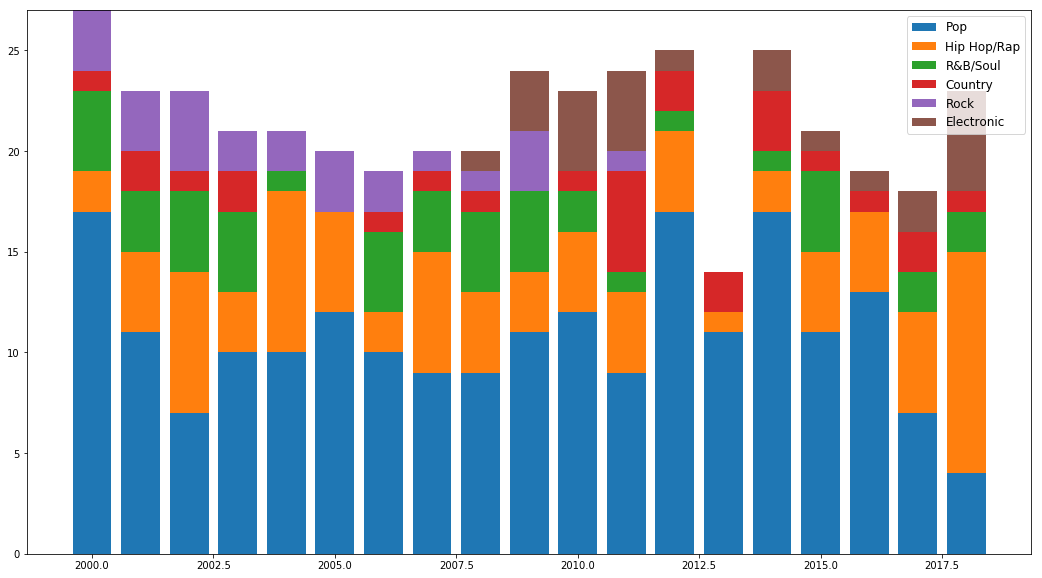

In [138]:
best_genre = df[df['0']>200].loc[:, ['genre', 'Year']].pivot_table(index="genre", columns="Year", aggfunc=len, fill_value=0)
genres = list(best_genre.sum(axis=1).sort_values(ascending=False).head().index)
genres.append('Electronic')
best_genre = best_genre.loc[genres, :]
plt.figure(figsize=(18, 10))
plt.bar(list(range(2000, 2019)), best_genre.iloc[0, :])
plt.bar(list(range(2000, 2019)), best_genre.iloc[1, :], bottom=best_genre.iloc[0, :])
plt.bar(list(range(2000, 2019)), best_genre.iloc[2, :], bottom=best_genre.iloc[:2, :].sum())
plt.bar(list(range(2000, 2019)), best_genre.iloc[3, :], bottom=best_genre.iloc[:3, :].sum())
plt.bar(list(range(2000, 2019)), best_genre.iloc[4, :], bottom=best_genre.iloc[:4, :].sum())
plt.bar(list(range(2000, 2019)), best_genre.iloc[5, :], bottom=best_genre.iloc[:5, :].sum())
#for i in range(1, 4):
#    plt.bar(list(range(2000, 2019)), genre_year.iloc[i, :], bottom=genre_year.iloc[:i-1, :].sum())
plt.legend(genres, prop={'size': 12})
plt.show()